In [1]:
import os
import random
import torch
import numpy as np

# 무적의 시드 고정
실험 결과의 일관성을 위해 여러번 돌려도 같은 랜덤값이 나오도록 seed를 고정합니다.

In [2]:
SEED = 2021
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
import os
import random
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from utils.report import AverageMeter
from utils.metrics import calculate_accuracy

import warnings

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings('ignore')

In [4]:
BATCH_SIZE = 256
LR = 0.001
ES_THRES = 10
EPOCHS = 100

# SVHN 데이터셋 다운로드

In [5]:
from torchvision.datasets import SVHN
import torchvision.transforms as transforms

### TASK 1
딥러닝을 공부하던 지훈이는 문득 normalization을 쓰는게 정말로 도움이 될지 궁금했습니다. 지훈이의 궁금증을 해결하기 위해, train 데이터셋의 mean과 std를 계산해서 train data를 normalization 했을때와 안했을때의 성능을 아래와 같이 비교해주세요. (TASK 2를 수행하기 전 default 모델로 실험.)

|  | loss | acc (%)   |
|------|------|------|
|   w/ normalization  | 0.43568955507932927| 88.33799958229065|
|   wo/ normalization  | 0.42598098545682195| 88.01561594009399|

데이터셋 normalization을 하고 학습을 진행할 경우, valid data와 test data도 train data의 mean과 std를 가지고 normalization해야합니다. 그런데 지훈이는 그냥 train, valid test 데이터를 한번에 normalization을 해서 그 결과를 사용했더니 test accuracy가 더 높게 나왔습니다. 하지만 그건 잘못된 방식이라고 교수님께 혼났습니다. 지훈이의 방식은 왜 잘못된 방식일까요? 이유를 발표 PPT에 포함해주세요.

In [6]:
download_root = './datasets/SVHN_DATASET'
train_data = SVHN(download_root, split="train", download=True)

# mean = 
# std = 

# print(f'Calculated mean: {mean}')
# print(f'Calculated std: {std}')

train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

Using downloaded and verified file: ./datasets/SVHN_DATASET/train_32x32.mat


In [7]:
train_valid_dataset = SVHN(download_root, transform=train_transforms, split="train", download=True)
train_dataset, valid_dataset = random_split(train_valid_dataset, [65931, 7326])
test_dataset = SVHN(download_root, transform=test_transforms, split="test", download=True)

Using downloaded and verified file: ./datasets/SVHN_DATASET/train_32x32.mat
Using downloaded and verified file: ./datasets/SVHN_DATASET/test_32x32.mat


In [8]:
len(train_dataset)

65931

In [9]:
len(valid_dataset)

7326

# Models 

### TASK 2
이 feature extractor와 classifier 코드는, 어느날 심심했던 지훈이가 만든 feature extractor, classifier입니다. 노오력이 부족했기 때문에, 정확도가 88% 정도밖에 되지 않았습니다. 이 형편없는 모델을 activation function을 사용하고, 채널 개수를 변경하고, dropout을 적용해서, hyper parameter튜닝 후, 최종 test accuracy를 90% 이상으로 올려주세요. 단, conv layer와 fully connected layer의 수를 변경해선 안됩니다. 어떤 방식으로 90%를 넘었는지, 사용한 방식이 왜 유효했는지에 대한 설명을 발표 PPT에 포함해주세요.

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self, in_channel_dim=3, out_channel_dim=16):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel_dim, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=out_channel_dim, kernel_size=5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.pool(x)
        
#         x = x.view(-1, 16 * 5 * 5)

        return x

In [11]:
class Classifier(nn.Module):
    def __init__(self, in_dim, out_dim=10):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(in_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        x = self.fc3(x)
        
        return x

# Train/Eval Functions

In [12]:
def train_loop_classifier(feature_extractor, classifier, train_loader, loss_func, optimizer, 
                          summary_loss, summary_acc=None, device=None):
    feature_extractor.train()
    classifier.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if device is not None:
            data, target = data.to(device), target.to(device)
            
        optimizer.zero_grad()
        feature = feature_extractor(data)
        feature = torch.flatten(feature, 1)
        output = classifier(feature)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        summary_loss.update(loss.detach().item(), BATCH_SIZE)
        if summary_acc is not None:
            acc = calculate_accuracy(output, target)
            summary_acc.update(acc, BATCH_SIZE)
        
    return summary_loss, summary_acc

def eval_loop_classifier(feature_extractor, classifier, valid_loader, loss_func, optimizer, 
                         summary_loss, summary_acc=None, device=None):
    feature_extractor.eval()
    classifier.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            if device is not None:
                data, target = data.to(device), target.to(device)

            feature = feature_extractor(data)
            feature = torch.flatten(feature, 1)
            output = classifier(feature)

            loss = loss_func(output, target)

            summary_loss.update(loss.detach().item(), BATCH_SIZE)
            if summary_acc is not None:
                acc = calculate_accuracy(output, target)
                summary_acc.update(acc, BATCH_SIZE)

    return summary_loss, summary_acc

### TASK 3-1
아래의 함수는 TSNE를 사용해 data 의 dimension을 줄이고, seaborn, matplotlib 그래프 라이브러리를 사용해서 input data가 feature extractor를 거쳐 어떻게 분포되는지 그래프를 그립니다. 이 함수를 완성해서, 학습이 진행됨에 따라 feature space가 어떤 모양으로 수렴하는지 알아보세요. 5 epoch마다 scatter plot을 그려보세요.
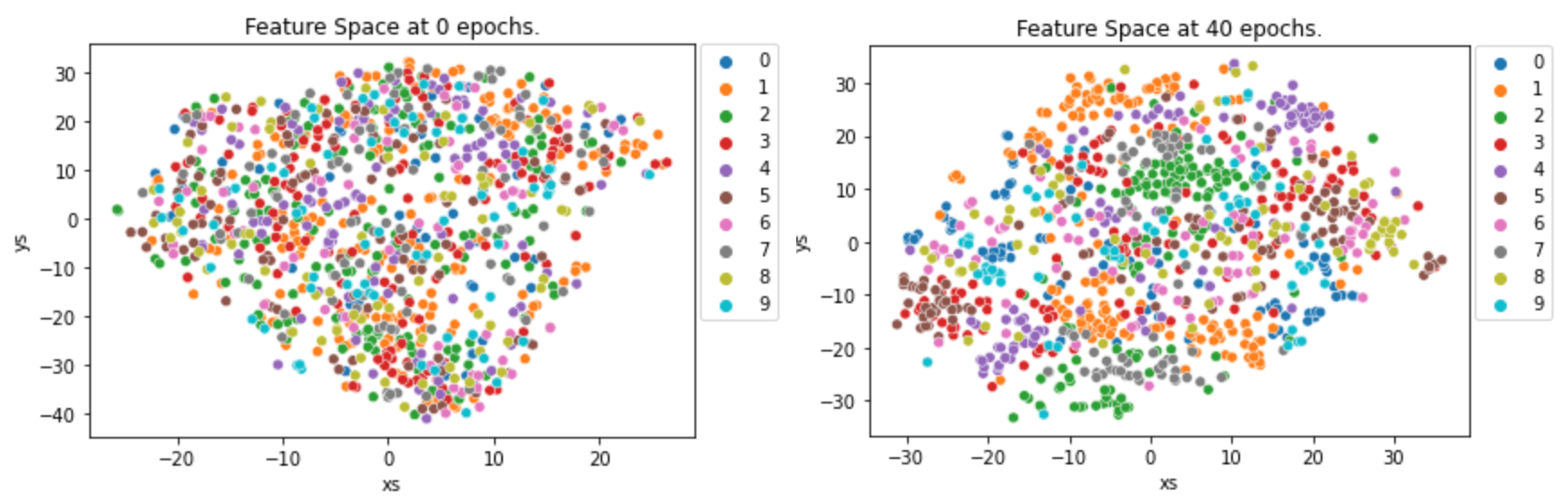
보시다시피 이 scatter plot은 보기가 상당히 어지럽습니다. 시간이 남는다면, 이 형편없는 시각화보다 학습의 정도를 잘 판별할 수 있는 시각화 방법을 조사하거나, 알고 있는 방법을 공유해주세요.

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_space(test_dataset, feature_extractor, plot_title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(dataset=test_dataset, 
                                 batch_size=1000,
                                 shuffle=True)
    feature_extractor.eval()
    features = []
    class_labels = []
    for data, label in test_loader:
        data = data.to(device)

        feature = feature_extractor(data)
        feature = torch.flatten(feature, 1)
        features.append(feature.detach())

        class_labels.append(label)
        break
    
    # Plot feature space
    model = TSNE(learning_rate=100, random_state=SEED)
    transformed = model.fit_transform(torch.cat(features, dim=0).cpu().numpy())

    tsne_df = pd.DataFrame({
        "xs": transformed[:,0],
        "ys": transformed[:,1],
        "label": torch.cat(class_labels, dim=0).cpu().numpy(),
    })

    tsne_df = tsne_df.sort_values(by="label")
    sns.scatterplot(x="xs",
                    y="ys",
                    hue="label",
                    palette="tab10",
                    data=tsne_df)
    plt.title(plot_title)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show()

# Training with Early Stopping

### TASK 4
지훈이는 Early stopping을 왜 쓰는지 도저히 이해가 되지 않았습니다. Early stopping을 써야하는 이유는 무엇인지, second training은 무엇인지 설명해주세요.
[이 링크](https://www.deeplearningbook.org/contents/regularization.html)의 7.8 Early stopping 파트를 참고하시면 좋습니다.

In [14]:
def run_training():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = FeatureExtractor()
    classifier = Classifier(400)

    feature_extractor.to(device)
    classifier.to(device)
    
    feature_extractor.train()
    classifier.train()

    criterion = nn.CrossEntropyLoss()
    criterion.to(device)
    
    model_parameters = list(feature_extractor.parameters()) + list(classifier.parameters())
    optimizer = optim.Adam(model_parameters, lr=LR)

    train_loader = DataLoader(dataset=train_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)

    valid_loader = DataLoader(dataset=valid_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)

    test_loader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)

    best_epoch = None
    best_loss = None
    epoch = 0
    es_count = 0
    while(epoch < EPOCHS):
        if epoch % 5 == 0:
            plot_feature_space(train_dataset, feature_extractor, f"Feature Space at {epoch} epochs.")
        
        epoch += 1
        summary_loss_train = AverageMeter()
        summary_acc_train = AverageMeter()
        summary_loss_valid = AverageMeter()
        summary_acc_valid = AverageMeter()

        summary_loss_train, summary_acc_train = train_loop_classifier(feature_extractor, classifier, train_loader, 
                                                   criterion, optimizer, summary_loss_train, summary_acc_train, device=device)
        summary_loss_valid, summary_acc_valid = eval_loop_classifier(feature_extractor, classifier, valid_loader, 
                                                   criterion, optimizer, summary_loss_valid, summary_acc_valid, device=device)

        print(f"[epoch]{epoch} [train loss]{summary_loss_train.avg} [train acc]{summary_acc_train.avg}  [valid loss]{summary_loss_valid.avg} [valid acc]{summary_acc_valid.avg} ")
        
        if best_loss is None:
            best_loss = summary_loss_valid.avg
            best_epoch = epoch

        if best_loss > summary_loss_valid.avg:
            best_loss = summary_loss_valid.avg
            best_epoch = epoch
            es_count = 0
        else:
            es_count += 1

        if es_count == ES_THRES:
            break

    print(f"Best epoch: {best_epoch}")
    return best_epoch

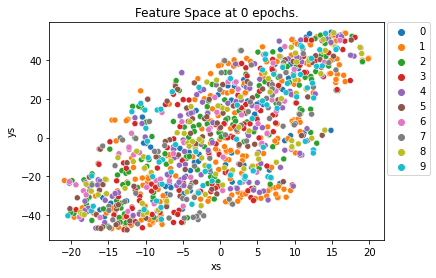

[epoch]1 [train loss]2.2390195759691935 [train acc]0.18917329609394073  [valid loss]2.2424786173064133 [valid acc]0.1835920363664627 
[epoch]2 [train loss]2.2381636772968974 [train acc]0.18984264135360718  [valid loss]2.2434369777810983 [valid acc]0.18300721049308777 
[epoch]3 [train loss]2.237534206967021 [train acc]0.18972794711589813  [valid loss]2.2400863581690293 [valid acc]0.1834249496459961 
[epoch]4 [train loss]1.89966467230819 [train acc]0.33797067403793335  [valid loss]1.506651705708997 [valid acc]0.46498358249664307 
[epoch]5 [train loss]1.2782226172528526 [train acc]0.5667572021484375  [valid loss]1.0834046026756023 [valid acc]0.6506335735321045 


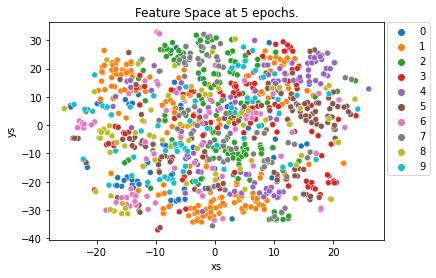

[epoch]6 [train loss]0.988934117463208 [train acc]0.6850522756576538  [valid loss]0.8939234840458837 [valid acc]0.7214370965957642 
[epoch]7 [train loss]0.8339483061040095 [train acc]0.740423321723938  [valid loss]0.7735596566364683 [valid acc]0.7668815851211548 
[epoch]8 [train loss]0.7414561096549959 [train acc]0.7723897099494934  [valid loss]0.6951523752048098 [valid acc]0.7919167280197144 
[epoch]9 [train loss]0.6759932626818501 [train acc]0.7935490012168884  [valid loss]0.6474418372943483 [valid acc]0.8088188171386719 
[epoch]10 [train loss]0.6307595130778099 [train acc]0.8084871172904968  [valid loss]0.6110440667333275 [valid acc]0.8176253437995911 


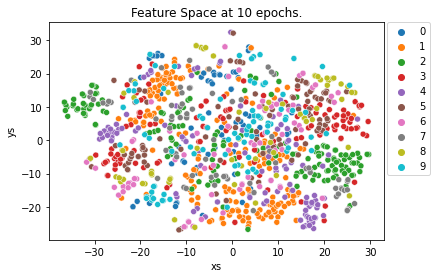

[epoch]11 [train loss]0.5920259529768035 [train acc]0.8203070759773254  [valid loss]0.5967025705452623 [valid acc]0.8191155195236206 
[epoch]12 [train loss]0.5617322614488676 [train acc]0.830282986164093  [valid loss]0.5544017090879637 [valid acc]0.8347729444503784 
[epoch]13 [train loss]0.5381568084622539 [train acc]0.838329017162323  [valid loss]0.549925492755298 [valid acc]0.8330917954444885 
[epoch]14 [train loss]0.5181578506332959 [train acc]0.8446409702301025  [valid loss]0.5176024837740536 [valid acc]0.8444064259529114 
[epoch]15 [train loss]0.49740902779176255 [train acc]0.8501752614974976  [valid loss]0.5077153074330297 [valid acc]0.8442580699920654 


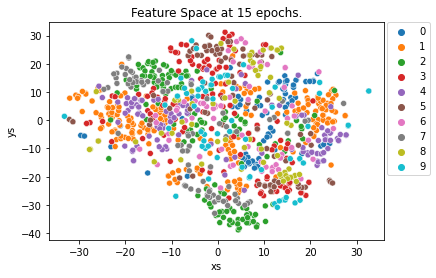

[epoch]16 [train loss]0.4848527986873952 [train acc]0.8540297746658325  [valid loss]0.49462622198565254 [valid acc]0.852674126625061 
[epoch]17 [train loss]0.4663564302893572 [train acc]0.8603999018669128  [valid loss]0.4757519426016972 [valid acc]0.8589811325073242 
[epoch]18 [train loss]0.4575922216555869 [train acc]0.863431990146637  [valid loss]0.47123318910598755 [valid acc]0.8582292199134827 
[epoch]19 [train loss]0.4432258408430011 [train acc]0.867637038230896  [valid loss]0.4625865950666625 [valid acc]0.8628924489021301 
[epoch]20 [train loss]0.4311976057383441 [train acc]0.8713767528533936  [valid loss]0.449988205885065 [valid acc]0.8685447573661804 


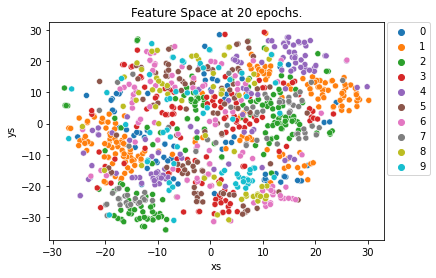

[epoch]21 [train loss]0.42361919986185176 [train acc]0.8728103041648865  [valid loss]0.4480525152436618 [valid acc]0.8653818368911743 
[epoch]22 [train loss]0.411584022202233 [train acc]0.8774504661560059  [valid loss]0.4371600767661785 [valid acc]0.8692182302474976 
[epoch]23 [train loss]0.4023811676243479 [train acc]0.8796259164810181  [valid loss]0.42898355784087344 [valid acc]0.8700451850891113 
[epoch]24 [train loss]0.3969705851618634 [train acc]0.8820117712020874  [valid loss]0.4286355884938404 [valid acc]0.8733563423156738 
[epoch]25 [train loss]0.386454928637475 [train acc]0.8854319453239441  [valid loss]0.42620064061263513 [valid acc]0.8730409145355225 


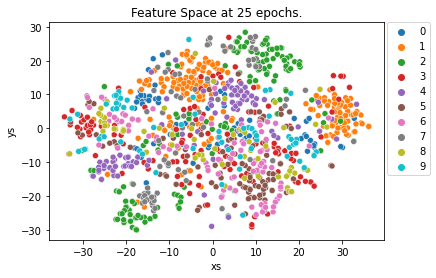

[epoch]26 [train loss]0.37912191849115284 [train acc]0.8870702385902405  [valid loss]0.4181196504625781 [valid acc]0.8768124580383301 
[epoch]27 [train loss]0.372618003120256 [train acc]0.8897445201873779  [valid loss]0.3990310127365178 [valid acc]0.880867063999176 
[epoch]28 [train loss]0.3651902259204739 [train acc]0.8910394906997681  [valid loss]0.40194548923393775 [valid acc]0.8796922564506531 
[epoch]29 [train loss]0.35901638790387513 [train acc]0.8928914070129395  [valid loss]0.3968111656863114 [valid acc]0.8852848410606384 
[epoch]30 [train loss]0.35428549487923466 [train acc]0.8943448662757874  [valid loss]0.3923915860981777 [valid acc]0.8794364929199219 


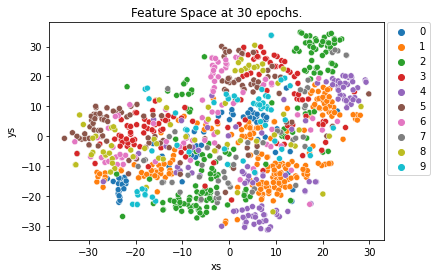

[epoch]31 [train loss]0.3462106815950815 [train acc]0.8970199823379517  [valid loss]0.38983080099368916 [valid acc]0.8829062581062317 
[epoch]32 [train loss]0.3428282591608144 [train acc]0.8976152539253235  [valid loss]0.39406970914067896 [valid acc]0.8852285146713257 
[epoch]33 [train loss]0.3367062012932097 [train acc]0.9000656008720398  [valid loss]0.38234085975022153 [valid acc]0.8860043287277222 
[epoch]34 [train loss]0.32959835150445155 [train acc]0.9020999670028687  [valid loss]0.3797022422839855 [valid acc]0.8879548907279968 
[epoch]35 [train loss]0.32355680986661317 [train acc]0.9037024974822998  [valid loss]0.3723077928197795 [valid acc]0.8908722400665283 


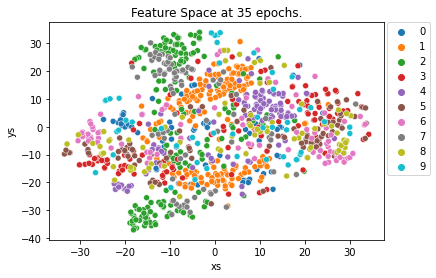

[epoch]36 [train loss]0.32164815362802773 [train acc]0.9041718244552612  [valid loss]0.37831342220306396 [valid acc]0.8893445134162903 
[epoch]37 [train loss]0.3160098446894062 [train acc]0.9056277275085449  [valid loss]0.37243715956293305 [valid acc]0.8883129358291626 
[epoch]38 [train loss]0.3110075671543447 [train acc]0.9071896076202393  [valid loss]0.37097961532658547 [valid acc]0.8902634978294373 
[epoch]39 [train loss]0.30596707235704096 [train acc]0.9086207151412964  [valid loss]0.37396052942193786 [valid acc]0.8890751004219055 
[epoch]40 [train loss]0.30381809290527373 [train acc]0.9096152186393738  [valid loss]0.36560670517641924 [valid acc]0.891796350479126 


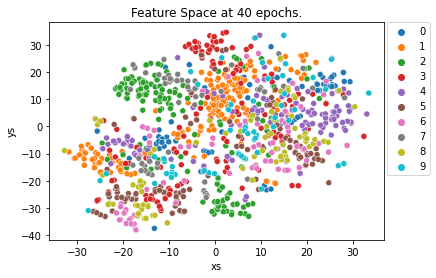

[epoch]41 [train loss]0.29754587060721344 [train acc]0.9120321273803711  [valid loss]0.36425336989863166 [valid acc]0.8941373825073242 
[epoch]42 [train loss]0.29519795242321584 [train acc]0.9108336567878723  [valid loss]0.37492123143426304 [valid acc]0.8895900249481201 
[epoch]43 [train loss]0.2890110599786736 [train acc]0.9137381911277771  [valid loss]0.3613765214023919 [valid acc]0.8931944966316223 
[epoch]44 [train loss]0.28289650744476985 [train acc]0.9157240390777588  [valid loss]0.36573362093547296 [valid acc]0.891847550868988 
[epoch]45 [train loss]0.28094738900892496 [train acc]0.9166675209999084  [valid loss]0.3549731969833374 [valid acc]0.8948944211006165 


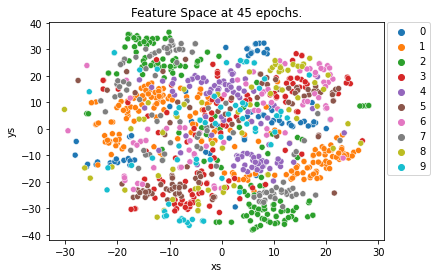

[epoch]46 [train loss]0.2786723030514495 [train acc]0.9172883033752441  [valid loss]0.3649052160567251 [valid acc]0.8940538167953491 
[epoch]47 [train loss]0.2737751601971397 [train acc]0.9187090992927551  [valid loss]0.37707955056223375 [valid acc]0.8883129358291626 
[epoch]48 [train loss]0.2691858960676563 [train acc]0.9209020733833313  [valid loss]0.3604463421065232 [valid acc]0.8930086493492126 
[epoch]49 [train loss]0.2663240237522495 [train acc]0.9211825728416443  [valid loss]0.35418024350856914 [valid acc]0.8966778516769409 
[epoch]50 [train loss]0.26170468058928037 [train acc]0.922622561454773  [valid loss]0.3531757490388278 [valid acc]0.8957400918006897 


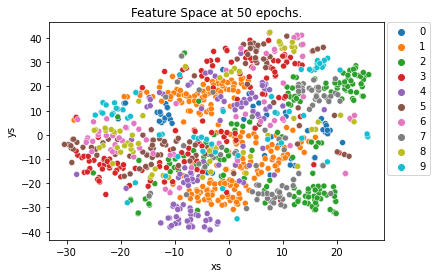

[epoch]51 [train loss]0.25966509009978567 [train acc]0.922696590423584  [valid loss]0.3505632214505097 [valid acc]0.9007052183151245 
[epoch]52 [train loss]0.2541028749804164 [train acc]0.9249645471572876  [valid loss]0.35307166391405564 [valid acc]0.8993257880210876 
[epoch]53 [train loss]0.2527544332682624 [train acc]0.9255740642547607  [valid loss]0.36062158335899486 [valid acc]0.8948245048522949 
[epoch]54 [train loss]0.24866298863361047 [train acc]0.9266331195831299  [valid loss]0.35508824576591624 [valid acc]0.8977742791175842 
[epoch]55 [train loss]0.24643510903498922 [train acc]0.9272993206977844  [valid loss]0.3572558904516286 [valid acc]0.8986335396766663 


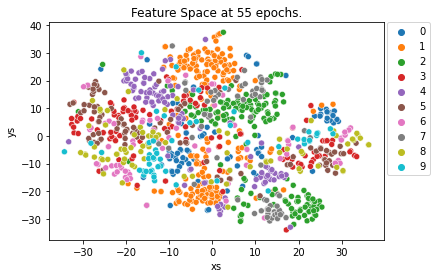

[epoch]56 [train loss]0.24224023538273434 [train acc]0.9281750917434692  [valid loss]0.3535883591092866 [valid acc]0.8981783390045166 
[epoch]57 [train loss]0.23885264449803403 [train acc]0.9298126697540283  [valid loss]0.34814151350794165 [valid acc]0.9008024334907532 
[epoch]58 [train loss]0.23561540999731354 [train acc]0.9308342933654785  [valid loss]0.3589167872379566 [valid acc]0.8961578607559204 
[epoch]59 [train loss]0.23131457756656085 [train acc]0.9331387877464294  [valid loss]0.35111297718409834 [valid acc]0.8981783390045166 
[epoch]60 [train loss]0.23028865857988365 [train acc]0.9324853420257568  [valid loss]0.358022842941613 [valid acc]0.8997111320495605 


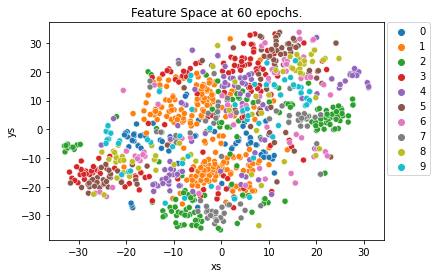

[epoch]61 [train loss]0.2289909779332405 [train acc]0.9326160550117493  [valid loss]0.35771499779717675 [valid acc]0.8967154026031494 
[epoch]62 [train loss]0.22471214368823886 [train acc]0.9338926672935486  [valid loss]0.3528728957833915 [valid acc]0.9003010988235474 
[epoch]63 [train loss]0.2220217695012111 [train acc]0.9357525110244751  [valid loss]0.3493380253684932 [valid acc]0.8992747068405151 
[epoch]64 [train loss]0.21827003356906793 [train acc]0.9362872242927551  [valid loss]0.35616741200973245 [valid acc]0.8975747227668762 
[epoch]65 [train loss]0.21471442868427712 [train acc]0.9380363821983337  [valid loss]0.3495253103560415 [valid acc]0.9023028612136841 


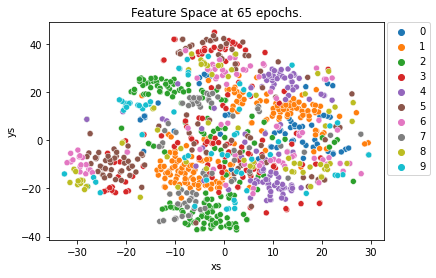

[epoch]66 [train loss]0.2123613686466864 [train acc]0.9381853342056274  [valid loss]0.3520370762923668 [valid acc]0.8974537253379822 
[epoch]67 [train loss]0.21026355132114055 [train acc]0.9392850399017334  [valid loss]0.35755834086187954 [valid acc]0.8988057971000671 
Best epoch: 57


In [15]:
best_epoch = run_training()

# Second Training

In [16]:
def run_second_training(best_epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = FeatureExtractor()
    classifier = Classifier(400)

    feature_extractor.to(device)
    classifier.to(device)
    
    feature_extractor.train()
    classifier.train()
    
    train_valid_loader = DataLoader(dataset=train_valid_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)

    criterion = nn.CrossEntropyLoss()
    model_parameters = list(feature_extractor.parameters()) + list(classifier.parameters())
    optimizer = optim.Adam(model_parameters, lr=LR)

    epoch = 0
    for _ in range(best_epoch):
        epoch += 1
        summary_loss_train = AverageMeter()
    #     summary_acc_train = AverageMeter()

        summary_loss_train, _ = train_loop_classifier(feature_extractor, classifier, train_valid_loader, 
                                                   criterion, optimizer, summary_loss_train, None, device=device)

        print(f"[epoch]{epoch} [train loss]{summary_loss_train.avg}")
    return feature_extractor, classifier

In [17]:
feature_extractor, classifier = run_second_training(best_epoch)

[epoch]1 [train loss]2.2398058038970734
[epoch]2 [train loss]2.2380238842050373
[epoch]3 [train loss]2.2380187810505725
[epoch]4 [train loss]1.9019979130515654
[epoch]5 [train loss]1.2054565339138283
[epoch]6 [train loss]0.9628965312595567
[epoch]7 [train loss]0.8127752141670067
[epoch]8 [train loss]0.7174867115369657
[epoch]9 [train loss]0.6537880666995298
[epoch]10 [train loss]0.6089911860663716
[epoch]11 [train loss]0.5708355142472098
[epoch]12 [train loss]0.5425207055196529
[epoch]13 [train loss]0.5149535668643925
[epoch]14 [train loss]0.49409841681191313
[epoch]15 [train loss]0.47457488114825525
[epoch]16 [train loss]0.4578362943195715
[epoch]17 [train loss]0.441484061371574
[epoch]18 [train loss]0.43004986612638946
[epoch]19 [train loss]0.41557825629304096
[epoch]20 [train loss]0.40384065980279904
[epoch]21 [train loss]0.3920228244016395
[epoch]22 [train loss]0.3832035198651955
[epoch]23 [train loss]0.3737990056596151
[epoch]24 [train loss]0.3642477213505669
[epoch]25 [train loss

In [18]:
def run_test(feature_extractor, classifier):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    feature_extractor.eval()
    classifier.eval()
    
    test_loader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    
    summary_loss_test = AverageMeter()
    summary_acc_test = AverageMeter()

    summary_loss_test, summary_acc_test = eval_loop_classifier(feature_extractor, classifier, test_loader, 
                                               criterion, None, summary_loss_test, summary_acc_test, device=device)

    print(f"[test loss]{summary_loss_test.avg} [test acc]{summary_acc_test.avg}")

In [19]:
run_test(feature_extractor, classifier)

[test loss]0.39099739711074266 [test acc]0.8872514367103577


# Draw feature space

### TASK 3-2
`plot_feature_space`함수로 feature_extractor를 거쳐 나온 test data feature들을 dimension을 줄인 후 scatter plot에 나타내봅니다.

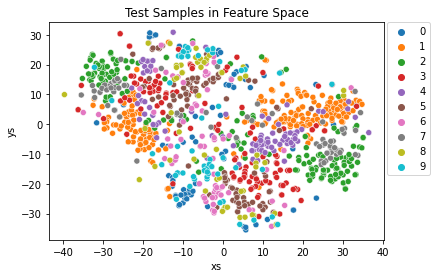

In [20]:
plot_feature_space(test_dataset, feature_extractor, "Test Samples in Feature Space")